In [1]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from pathlib import Path
from torchvision.ops import nms
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=125):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

### Load Model

In [3]:
device = torch.device('cuda:4')

processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14")
model.eval;
model.to(device);

# print all named model parameters
for name, param in model.named_parameters():
    print(name, param.shape)


owlvit.logit_scale torch.Size([])
owlvit.text_model.embeddings.token_embedding.weight torch.Size([49408, 768])
owlvit.text_model.embeddings.position_embedding.weight torch.Size([16, 768])
owlvit.text_model.encoder.layers.0.self_attn.k_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.k_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.v_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.v_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.q_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.q_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.out_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.out_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.layer_norm1.weight torch.Size([768])
owlvit.text_model.encoder.layers.0.layer_norm1.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.mlp

### Detect Objects

In [4]:
n = 0

In [5]:
# image_path = "/data/mwoedlinger/code/sustainibility-hackathon/sample_data2/data/image0000004.jpg"
# image_path = "/data/mwoedlinger/code/download-removebg-preview.png"
# image_path = "/data/mwoedlinger/code/image19-removebg-preview.png"
# image_path = "/data/mburges/for_matthias/images_hackathon/image19.jpg"
images = [img for img in Path('/data/mburges/for_matthias/images_hackathon').iterdir()]

# Load image
image_path = images[n]
image = Image.open(image_path).convert("RGB")
texts = [["object", "can", "bottle"]]
#texts = [["object", "can_shape, can_texture, can_opening", "bottle_shape, bottle_texture, bottle_cap"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

n += 1

/data/mburges/miniconda/envs/SegAny/lib/python3.10/site-packages/transformers/models/owlvit/image_processing_owlvit.py:355: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Detected object with confidence 0.131 at location [23.75, 26.58, 1934.81, 1210.45]
Detected bottle with confidence 0.565 at location [371.97, 165.01, 1272.79, 442.83]
Detected bottle with confidence 0.104 at location [388.12, 171.04, 1293.44, 446.8]
Detected bottle with confidence 0.288 at location [437.8, 165.04, 1290.7, 929.08]
Detected can with confidence 0.145 at location [705.74, 425.93, 1002.5, 941.03]
Detected bottle with confidence 0.443 at location [709.54, 428.45, 996.83, 933.12]
Detected object with confidence 0.144 at location [7.84, 69.88, 1924.34, 1196.66]
Detected bottle with confidence 0.414 at location [1246.56, 562.83, 1925.48, 1117.95]
Detected bottle with confidence 0.133 at location [1628.99, 747.38, 1914.31, 1003.14]
Detected bottle with confidence 0.12 at location [716.23, 491.2, 1918.73, 1100.39]


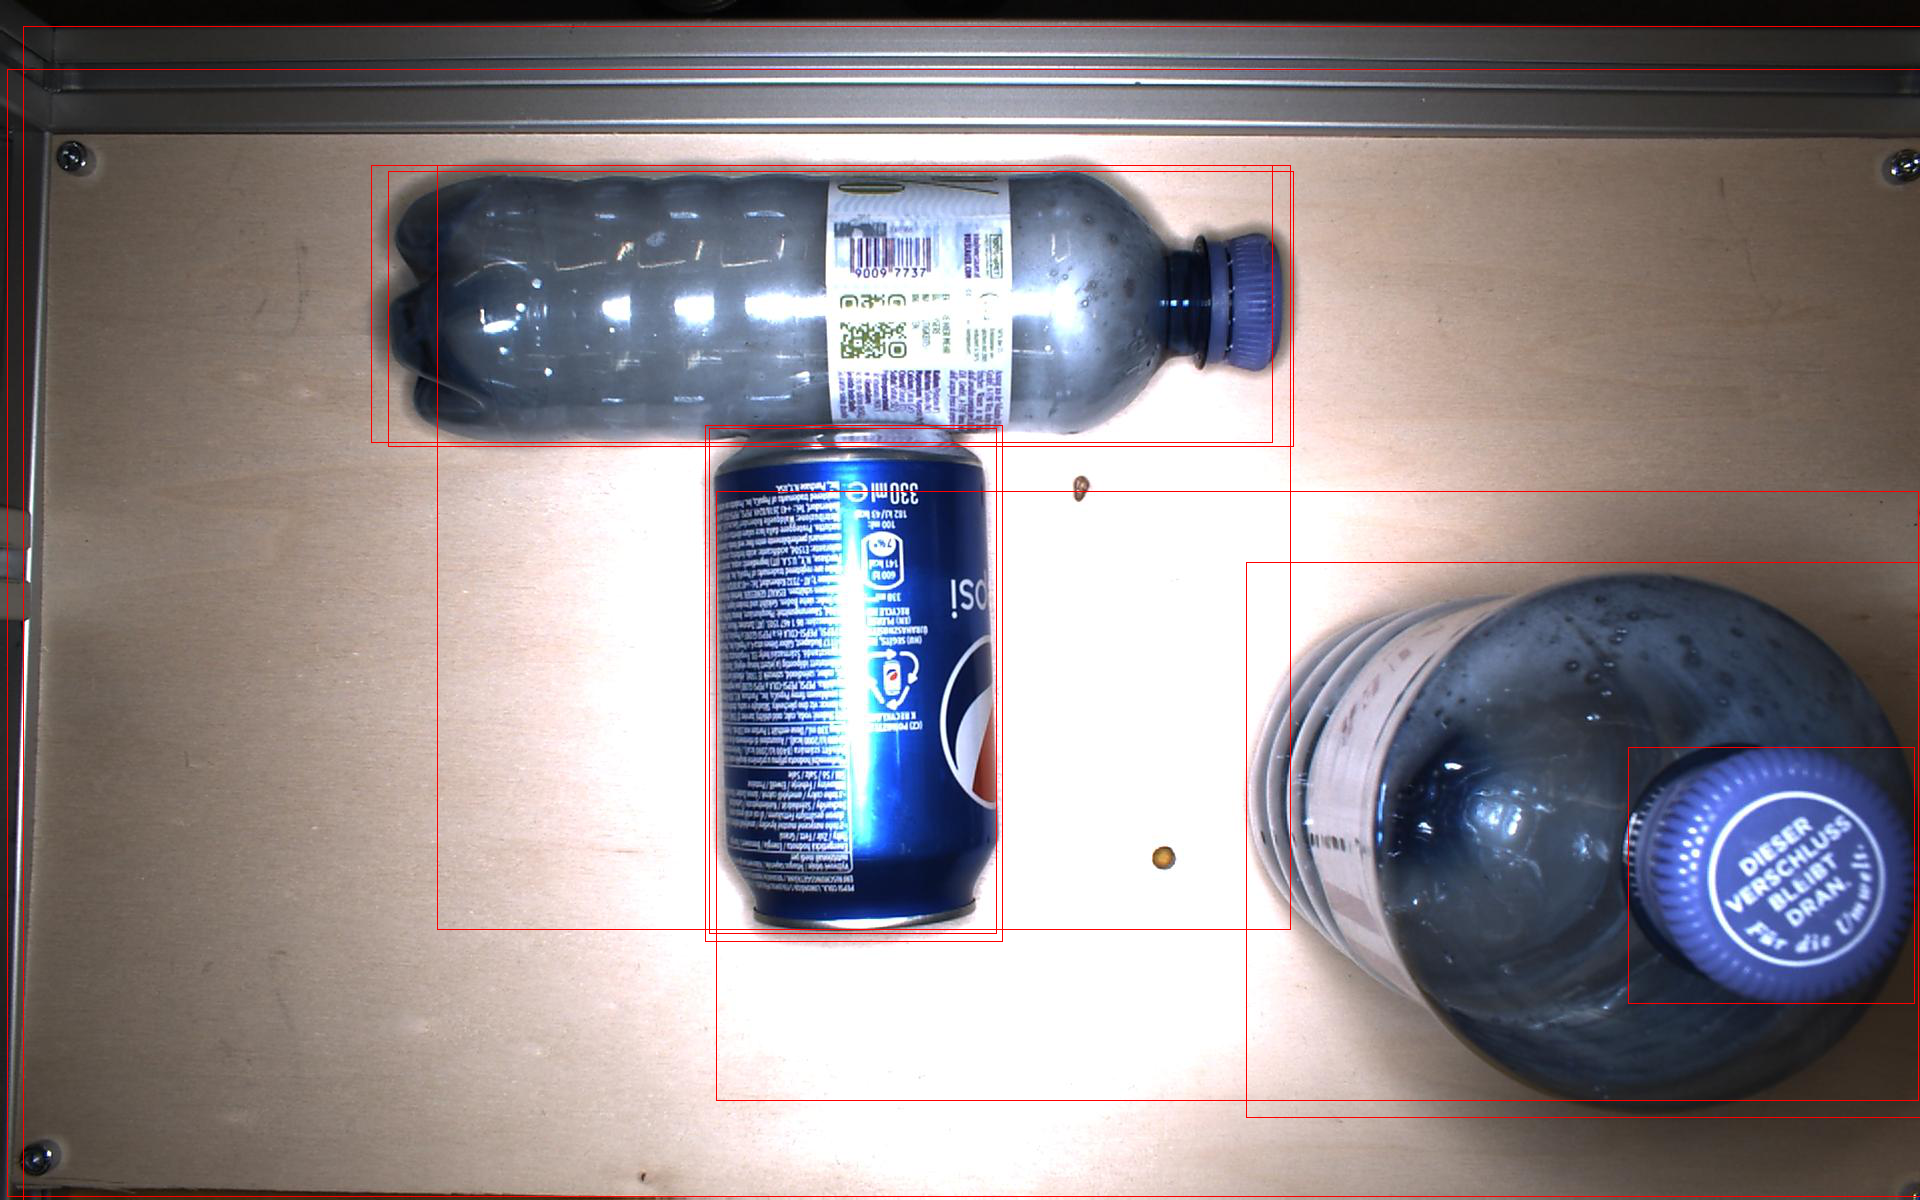

In [6]:
with torch.no_grad():
    outputs = model(**inputs.to(device))

# print(outputs.keys())
# for k, v in outputs.items():
#     print(k, v.shape)
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]]).to(device)
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
        
# visualize results with pillow
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.1:
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])), outline="red")
        #draw.text((boxes[i][0], boxes[i][1]), str(labels[i]) + " " + str(scores[i]), fill="red")
image.show()

### Non-maximum suppression

In [7]:
boxes_filtered = boxes[scores > 0.1]
scores_filtered = scores[scores > 0.1]
labels_filtered = labels[scores > 0.1]
embeddings_filtered = outputs['class_embeds'][0, scores > 0.1]

print("boxes", boxes.shape)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

boxes torch.Size([3600, 4])
logits: shape of torch.Size([1, 3600, 3])
pred_boxes: shape of torch.Size([1, 3600, 4])
text_embeds: shape of torch.Size([1, 3, 768])
image_embeds: shape of torch.Size([1, 60, 60, 1024])
class_embeds: shape of torch.Size([1, 3600, 768])


In [10]:
nms_out = nms(boxes_filtered, scores_filtered, iou_threshold=0.1)

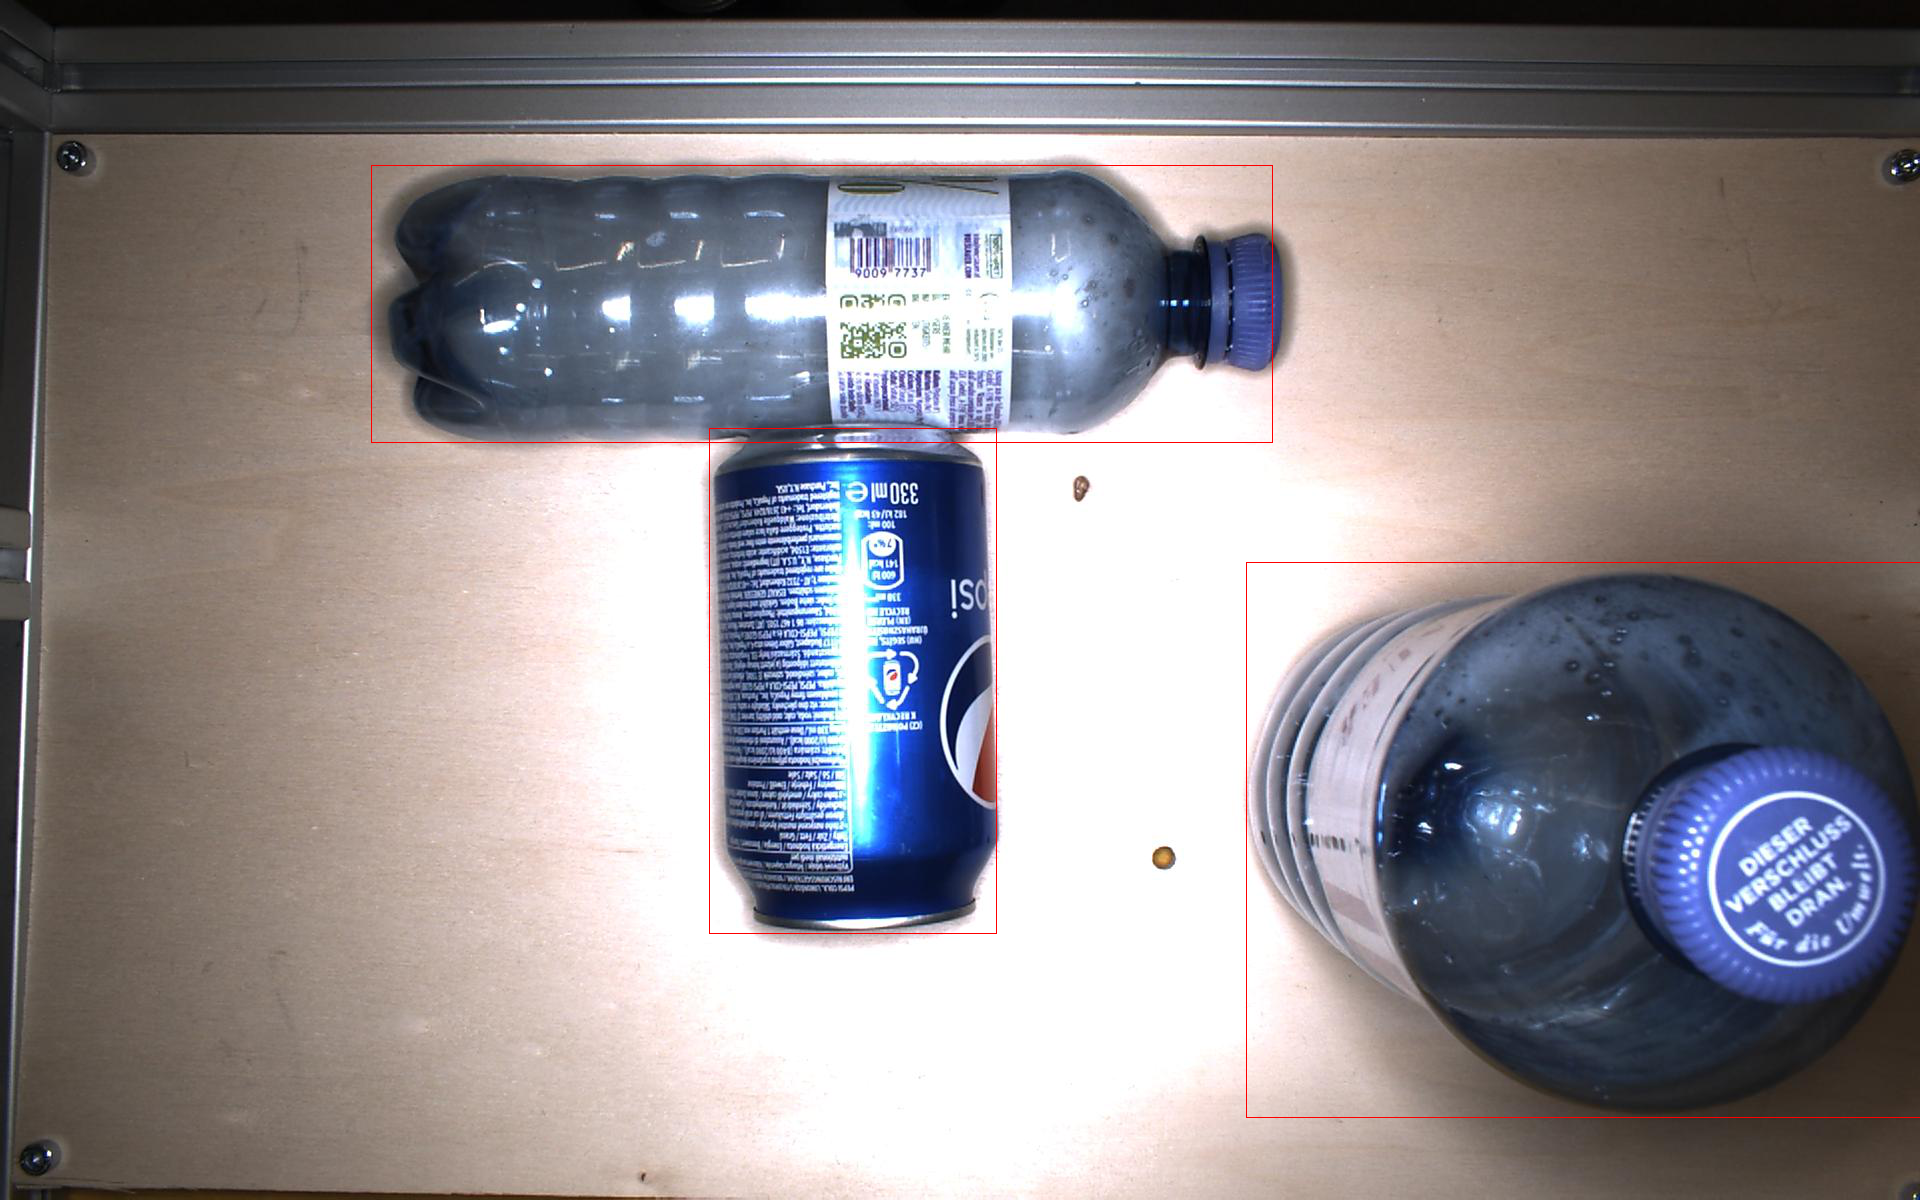

boxes_nms torch.Size([3, 4])
embeddings_nms torch.Size([3, 768])
labels_nms ['bottle', 'bottle', 'bottle']
torch.Size([768]) torch.Size([3, 768])
tensor([1.0000, 0.6049, 0.6225], device='cuda:4')
torch.Size([768]) torch.Size([3, 768])
tensor([0.6049, 1.0000, 0.5999], device='cuda:4')
torch.Size([768]) torch.Size([3, 768])
tensor([0.6225, 0.5999, 1.0000], device='cuda:4')


In [13]:
image_path = images[n-1]

# Load image
image = Image.open(image_path).convert("RGB")

# visualize results with pillow
draw = ImageDraw.Draw(image)
bounding_boxes = boxes_filtered[nms_out]
embeddings_nms = embeddings_filtered[nms_out]
labels_nms = labels_filtered[nms_out]
for i in range(len(bounding_boxes)):
    draw.rectangle(((bounding_boxes[i][0], bounding_boxes[i][1]), (bounding_boxes[i][2], bounding_boxes[i][3])), outline="red")
image.show()

#save image with just the date in the name
image_name = str(image_path).split("/")[-1]
image.save("/caa/Homes01/mburges/viennaup23-hackathon-recycling/backend/example_images/{}".format(image_name))

labels_in_image = []
for i in labels_nms:
    labels_in_image.append(text[i])

print("boxes_nms", bounding_boxes.shape)
print("embeddings_nms", embeddings_nms.shape)
print("labels_nms", labels_in_image)

# print cosine similarity between all pairs of bounding boxes torch
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
for emb in embeddings_nms:
    print(emb.shape, embeddings_nms.shape)
    print(cos(emb.unsqueeze(0), embeddings_nms))
